このPython コードは、GPy 等を使います。
* 2025年8月時点では、Google Colaboratory の default 環境では使えません。
    * 以下のコードのコメントアウトを外して実行すれば、動作すると思います。
* ローカルな計算機環境では、GPy 等を pip を使っていインストールできると思います。

    ```
    pip install GPy gpyopt pyDOE PyFoam
    ```
    * 2025年8月時点では、Anaconda の conda を使う方法は見つかりませんでした。

GPyOptパッケージのインストール
* https://sheffieldml.github.io/GPyOpt/

In [19]:
# ############################################
# # Google Colaboratory で利用するためには、このゼルのコメントアウトを外して実行してください。
# ############################################
# !pip install GPy
# !pip install gpyopt
# !pip install pyDOE
# !pip install PyFoam
# ############################################
# # 以下のエラーを回避するため　Google colab.
# # ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
# !pip install numpy==1.26.4

*   ベースディレクトリと、出力ディレクトリを設定します。

In [20]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2GPyOpt-1103demo/'
FileBaseName = '2GPyOpt-1103demo'

*   Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [21]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/


In [22]:
############################################
import GPy
# import GPyOpt
from GPyOpt.methods import BayesianOptimization

*   必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [23]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
# %matplotlib notebook
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
import pandas as pd
print('pandas     Ver.', pd.__version__)
#
############################################
from sklearn.preprocessing import MinMaxScaler
#
############################################
from mpl_toolkits.mplot3d import Axes3D
#
# ############################################
# # https://docs.pymc.io/
# import pymc as pm
# import time
# print('pymc       Ver.', pm.__version__)
#
# ############################################
# import pickle
#
# ############################################
# # 複数の png を mp4 に
# import cv2
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
pandas     Ver. 2.2.3
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2GPyOpt-1103demo/
 d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2GPyOpt-1103demo/ is exist.


最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [24]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  order_mean = np.floor( np.log10(v_mean) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    if latex:
      fmt_std1 = r'$%%+.%df$' % -order_std
      fmt_std2 = r'$%%.%df$'  % -order_std
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_std1 = r'%%+.%df' % -order_std
      fmt_std2 = r'%%.%df'  % -order_std
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

Rosenbrock関数

デモンストレーション用に、2変数のRosenbrock関数を元に、ベイズ最適化用の計測データを用意する。ただし、2変数の範囲は以下の範囲とする。
* $x_1=220\sim240$
* $x_2=0.5\sim1.5$

以下で定義される Rosenbrock関数は
$$
f(x_1',x_2') = (1.0-x_1')^2 + 100(x_2'-x_1'^2)^2 + c
$$
* $x_1',x_2'=-2.0\sim+2.0$
の範囲で、$(x_1',x_2')=(+1.0, +1.0)$で$c$に最小化することが知られている。

よって以下の変換をしておく。
* $x_1'=0.1\times(x_1-220)$
* $x_2'=4.0\times(x_2-1.0)$

よって$(x_1,x_2')=(+230.0, +1.25)$で$c$に最小化する

In [25]:
############################################
def Rosenbrock( x1, x2 ):
  return np.sqrt( (1-x1)**2 + 100*(x2-x1**2)**2 + 1 )
#   return (1-x1)**2 + 100*(x2-x1**2)**2 + 1
#
############################################
def rb_func( X_1, X_2 ):
  x_1 = 0.1 * (X_1 - 220)
  x_2 = 4.0 * (X_2 - 1.0)
  return Rosenbrock( x_1, x_2 )

Rosenbrock関数

デモンストレーション用に、2変数のRosenbrock関数を元に、ベイズ最適化用の計測データを用意する。ただし、2変数の範囲は以下の範囲とする。
* $x_1=210\sim240$
* $x_2=0.5\sim2.0$
のグラフを描く

In [26]:
############################################
def Grf2D_rb( measures=None, logs=None ):
  # 表示範囲
  x_1 = np.linspace(210, 240, 81, endpoint=True )
  x_2 = np.linspace(0.5, 2.0, 81, endpoint=True )
  #
  X_1,X_2 = np.meshgrid(x_1, x_2)
  #
  # Rosenbrock関数
  Z = rb_func(X_1,X_2)
  #
  # 最小点
  min_x_1 = 230
  min_x_2 = 1.25
  min_z   = rb_func(min_x_1,min_x_2)
  #
  # 色目盛
  Z_min = np.amin( Z )
  Z_max = np.amax( Z )
  levs = np.linspace( Z_min, Z_max, num=50 )
  #
  z12_min = Z_max
  x1_min_ = 0
  x2_min_ = 0
  for x1_ in x_1:
    for x2_ in x_2:
      z12_ = rb_func(x1_,x2_)
      if z12_ < z12_min:
        x1_min_ = x1_
        x2_min_ = x2_
        z12_min = z12_
  #
  # print( x1_min_, x2_min_ )
  #
  plt.rcParams['font.size'] = 20
  #
  fig = plt.figure( figsize=(6,6) )
  #
  fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( r'$x_{1}$' )
  ax1.set_ylabel( r'$x_{2}$' )
  #
  # 等高線図
  ax1.contour(x_1,x_2,Z,levels=levs,cmap="viridis")
  # plt.colorbar()
  #
  # 最小点
  ax1.axhline(y=x2_min_, linestyle='dashed', color='red' )
  ax1.axvline(x=x1_min_, linestyle='dashed', color='red' )
  ax1.text( x1_min_, x2_min_, '(%.1f)' % z12_min, fontsize=14, color='red' )
  #
  # 測定値等の表示
  if measures is not None:
    c_ = 1
    for measure in measures:
      x_1_ = measure[0]
      x_2_ = measure[1]
      z_   = measure[2]
      ax1.text( x_1_, x_2_, '(%d:%.1f)' % (c_,z_), fontsize=14, color='red' )
      ax1.scatter( x_1_, x_2_, color='red' )
      #
      c_ = c_ + 1
  #
  # ベイズ最適化履歴
  if logs is not None:
    c_ = 1
    for log in logs:
      x_1_ = log[0]
      x_2_ = log[1]
      z_   = log[2]
      # ax1.text( x_1_, x_2_, '(%d:%.1f)' % (c_,z_), fontsize=14, color='blue' )
      ax1.scatter( x_1_, x_2_, color='blue', s=10 )
      #
      c_ = c_ + 1
    #
    lenlog = len( logs )
    x1_prefer_ = logs[lenlog-1][0]
    x2_prefer_ = logs[lenlog-1][1]
    z_prefer_  = logs[lenlog-1][2]
    ax1.text( x1_prefer_, x2_prefer_, '(%d:%.1f)' % (lenlog,z_prefer_), fontsize=14, color='blue' )
    ax1.scatter( x1_prefer_, x2_prefer_, color='blue', s=20 )
  #
  plt.show()
  #
  return fig

In [27]:
# ############################################
# # デモのため乱数シードを設定
# np.random.seed(1346)
# #
# ############################################
# # 何点測定するか?
# measure_c = 10
# #
# ############################################
# # 測定をデモンストレーション
# measure = np.zeros( (measure_c,3 ) )
# measure[:,0] = 210 + 30  * np.random.rand( measure_c )
# measure[:,1] = 0.5 + 1.5 * np.random.rand( measure_c )
# measure[:,2] = rb_func(measure[:,0],measure[:,1])
# #
# ############################################
# # 測定結果をグラフ化
# fig = Grf2D_rb(measure)
# #
# fig.savefig( FilePath + FileBaseName + 'measures-01.pdf' )
# #
# ############################################
# # 測定結果をxlsxで出力
# df =pd.DataFrame( measure, columns=['x1','x2', 'y'])
# #
# df.to_excel( FilePath + FileBaseName + 'measures-01.xlsx' )

デモンストレーションのために用意したデータ(測定値を想定)を読み込む

In [28]:
############################################
xlsx_file = FilePath + FileBaseName + 'measures-01.xlsx'
df = pd.read_excel( xlsx_file )
df

,Unnamed: 0,x1,x2,y
0,0,237.725122,1.680048,4.401366
1,1,220.721783,0.787423,8.663243
2,2,212.398914,1.545300,16.161620
3,3,221.874378,1.092201,3.576872
4,4,221.751457,1.703834,27.876758
5,5,231.606117,0.528234,32.356688
6,6,237.114299,1.467077,10.677595
7,7,216.852618,1.255146,9.362116
8,8,233.589245,1.742039,11.265023
9,9,210.666355,0.941844,11.250513


In [29]:
############################################
# 測定点数
measures_c = len(df)
#
measures   = np.zeros( (measures_c,3 ) )
measures_x = np.zeros( (measures_c,2 ) )
measures_y = np.zeros( (measures_c,1 ) )
#
measures_x[:,0] = np.array( df['x1'] )
measures_x[:,1] = np.array( df['x2'] )
measures_y[:,0] = np.array( df['y'] )
print( measures_x )
print( measures_y )
#
measures[:,0] = measures_x[:,0]
measures[:,1] = measures_x[:,1]
measures[:,2] = measures_y[:,0]
print( measures )

[[237.72512236   1.68004816]
 [220.72178298   0.78742319]
 [212.39891419   1.54529971]
 [221.87437796   1.09220144]
 [221.75145737   1.70383406]
 [231.60611657   0.52823404]
 [237.11429885   1.46707723]
 [216.85261807   1.25514608]
 [233.5892454    1.74203916]
 [210.66635525   0.94184377]]
[[ 4.40136563]
 [ 8.66324306]
 [16.16162042]
 [ 3.57687207]
 [27.87675784]
 [32.35668775]
 [10.67759535]
 [ 9.36211632]
 [11.26502264]
 [11.25051339]]
[[237.72512236   1.68004816   4.40136563]
 [220.72178298   0.78742319   8.66324306]
 [212.39891419   1.54529971  16.16162042]
 [221.87437796   1.09220144   3.57687207]
 [221.75145737   1.70383406  27.87675784]
 [231.60611657   0.52823404  32.35668775]
 [237.11429885   1.46707723  10.67759535]
 [216.85261807   1.25514608   9.36211632]
 [233.5892454    1.74203916  11.26502264]
 [210.66635525   0.94184377  11.25051339]]


読み込んだデータ$x_{1}$, $x_{2}$を[0,1]にスケーリングします。

In [30]:
############################################
x_minmax = np.array( [ [210, 0.5],
                       [240, 2.0] ])
#
x_scaler = MinMaxScaler()
x_scaler.fit( x_minmax )
norm_measures_x = x_scaler.transform(measures_x)
norm_measures_x
#
y_scaler = MinMaxScaler()
y_scaler.fit( measures_y )
norm_measures_y = y_scaler.transform(measures_y)
norm_measures_y

array([[0.02864833],
       [0.17673397],
       [0.43727689],
       [0.        ],
       [0.84433778],
       [1.        ],
       [0.24672581],
       [0.20101742],
       [0.26713689],
       [0.26663275]])

$x_{1}$, $x_{2}$の探索範囲を設定。

In [31]:
############################################
# x_1, x_2の探索範囲の設定
bounds = [ {'name': 'x1', 'type': 'continuous', 'domain': (0.0, 1.0) },
           {'name': 'x2', 'type': 'continuous', 'domain': (0.0, 1.0) } ]

ベイズ最適化の1ステップ関数

In [32]:
############################################
def BayesOptLoop( x_set, y_set ):
  #
  #以下のパラメータでベイズ最適化を実行する
  params = {'acquisition_type':'EI', # 'EI', Expected Improvementを獲得関数に指定
            'f':None,                # 実験結果は分からないので設定しない
            'domain':bounds,         # パラメータの探索範囲指定
            'X':x_set,               # 既知データの説明変数（x）
            'Y':y_set,               # 既知データの目的変数（y）
            'de_duplication':True   # 重複したデータをサンプルしないように設定．
            }
  #
  # ベイズ最適化のモデルの作成
  # bo_step = GPyOpt.methods.BayesianOptimization( **params )
  bo_step = BayesianOptimization( **params )
  #
  # 次の候補点のx,y(予測値,分散)の計算
  x_suggest  = bo_step.suggest_next_locations(ignored_X=x_set)
  y_predict  = bo_step.model.model.predict(x_suggest) #y_predictは(予測平均，予測分散)がタプルで返ってくる
  # y_mean     = y_predict[0]
  # y_variance = y_predict[1]
  #
  return x_suggest, y_predict

試行する

In [33]:
############################################
x_suggest, y_predict = BayesOptLoop( norm_measures_x, measures_y )
# print( x_suggest )
print( x_scaler.inverse_transform(x_suggest) )
# print( y_predict )

[[240.           1.87600203]]


ベイズ最適化のsuggestionを取り込みながら、繰り返す。

In [34]:
############################################
y_prefer = 1.10
#
# 履歴
logs_x = norm_measures_x
logs_y = measures_y
#
y_measure = 10
#
i = 0
while y_measure > y_prefer:
  # for i in range(iters):
  #
  # ベイズ最適化ステップ
  x_suggest, y_predict = BayesOptLoop(logs_x, logs_y)
  #
  # suggestionされた x_1, x_2 を元の実パラメータスケールに戻す
  x_suggest_ = x_scaler.inverse_transform(x_suggest)
  x_1 = x_suggest_[0,0]
  x_2 = x_suggest_[0,1]
  #
  # y_mean    = y_predict[0]
  # y_std     = np.sqrt(y_predict[1])
  #
  # suggestionされた x_1, x_2 の実パラメータで実験する
  y_measure = rb_func(x_1, x_2)
  #
  print( '%3dth-suggestion: x1=%6.1f, x2=%5.2f, y_measue=%7.2f' %
        ((i+1), x_1, x_2, y_measure) )
  #
  # suggestionされたx1, x2 (スケールされた)を履歴に追加
  logs_x = np.concatenate( [logs_x, x_suggest] )
  #
  # 実験結果を追加
  logs_y = np.concatenate( [logs_y, np.asarray([[y_measure]])] )
  #
  i = i + 1

  1th-suggestion: x1= 240.0, x2= 1.88, y_measue=   5.16
  2th-suggestion: x1= 219.3, x2= 1.02, y_measue=   1.65
  3th-suggestion: x1= 210.0, x2= 0.50, y_measue=  30.08
  4th-suggestion: x1= 210.0, x2= 2.00, y_measue=  30.08
  5th-suggestion: x1= 240.0, x2= 1.67, y_measue=  13.22
  6th-suggestion: x1= 219.3, x2= 1.02, y_measue=   1.69
  7th-suggestion: x1= 237.3, x2= 2.00, y_measue=  10.17
  8th-suggestion: x1= 216.6, x2= 0.97, y_measue=   2.75
  9th-suggestion: x1= 228.6, x2= 1.16, y_measue=   1.32
 10th-suggestion: x1= 226.6, x2= 1.05, y_measue=   2.66
 11th-suggestion: x1= 232.0, x2= 1.13, y_measue=   9.45
 12th-suggestion: x1= 226.5, x2= 1.20, y_measue=   3.71
 13th-suggestion: x1= 210.0, x2= 1.23, y_measue=   2.33
 14th-suggestion: x1= 212.6, x2= 1.15, y_measue=   2.14
 15th-suggestion: x1= 230.3, x2= 1.33, y_measue=   2.81
 16th-suggestion: x1= 221.9, x2= 0.97, y_measue=   1.95
 17th-suggestion: x1= 229.2, x2= 1.22, y_measue=   1.13
 18th-suggestion: x1= 240.0, x2= 0.50, y_measue=

ベイズ最適化のステップデータを抜き出す

In [35]:
############################################
BO_logs = np.zeros( (len(logs_x)-measures_c,3 ) )
logs_x_ = x_scaler.inverse_transform(logs_x)
BO_logs[:,0] = logs_x_[measures_c:,0]
BO_logs[:,1] = logs_x_[measures_c:,1]
BO_logs[:,2] = logs_y[measures_c:,0]
BO_logs

array([[240.        ,   1.87600221,   5.15758888],
       [219.27872992,   1.02022212,   1.64993826],
       [210.        ,   0.5       ,  30.08321791],
       [210.        ,   2.        ,  30.08321791],
       [240.        ,   1.67132364,  13.22289815],
       [219.2957659 ,   1.02232313,   1.69027008],
       [237.2932644 ,   2.        ,  10.16989787],
       [216.58021153,   0.97473858,   2.74829011],
       [228.56316675,   1.1622678 ,   1.31519117],
       [226.60411658,   1.04798342,   2.66067026],
       [232.04694944,   1.12785351,   9.45402383],
       [226.54335239,   1.19583426,   3.70606809],
       [210.        ,   1.23344899,   2.33201572],
       [212.63954364,   1.15419433,   2.13929107],
       [230.30008684,   1.33097705,   2.81376823],
       [221.88403187,   0.97219516,   1.95223504],
       [229.1907681 ,   1.22428381,   1.13202074],
       [240.        ,   0.5       ,  60.01666435],
       [234.38797967,   1.54545182,   1.56189328],
       [233.36067116,   1.45382

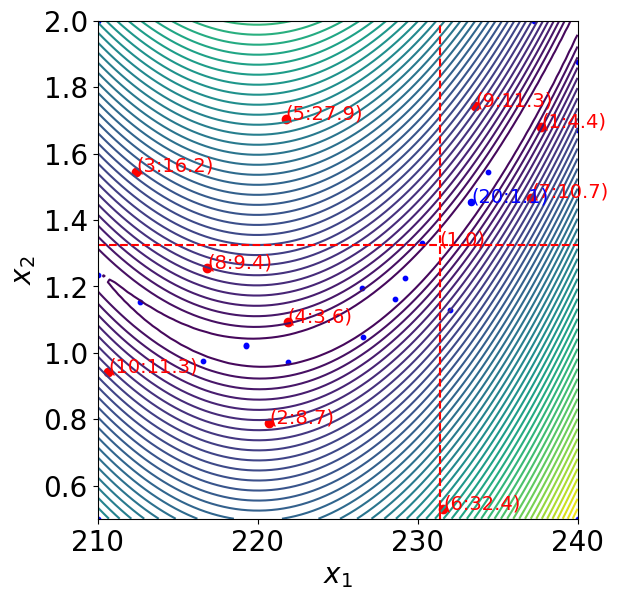

In [36]:
############################################
# 測定結果をグラフ化
fig = Grf2D_rb( measures=measures, logs=BO_logs )
#
fig.savefig( FilePath + FileBaseName + 'BOsteps-01.pdf' )
#
